In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import xesmf as xe
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import scipy
import scipy.stats
from defs import mmm, lon180, mask

In [2]:
folder = 'Data_processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [3]:
dsgrid = xr.open_dataset(folder+'1x1grid.nc')
area = dsgrid.area

#Open and calculate sea-ice cover
dsE280si = xr.open_dataset(folder+'MMM_ensemble/E280/SI_100yr.nc')
dsEoi400si = xr.open_dataset(folder+'MMM_ensemble/Eoi400/SI_100yr.nc')

siE280 = mmm(dsE280si.si_mean)
siEoi400 = mmm(dsEoi400si.si_mean)

#Open and calculate zonal wind
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/UVa_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/UVa_100yr.nc')

mmmE280 = mmm(dsE280.ua)
mmmEoi400 = mmm(dsEoi400.ua)

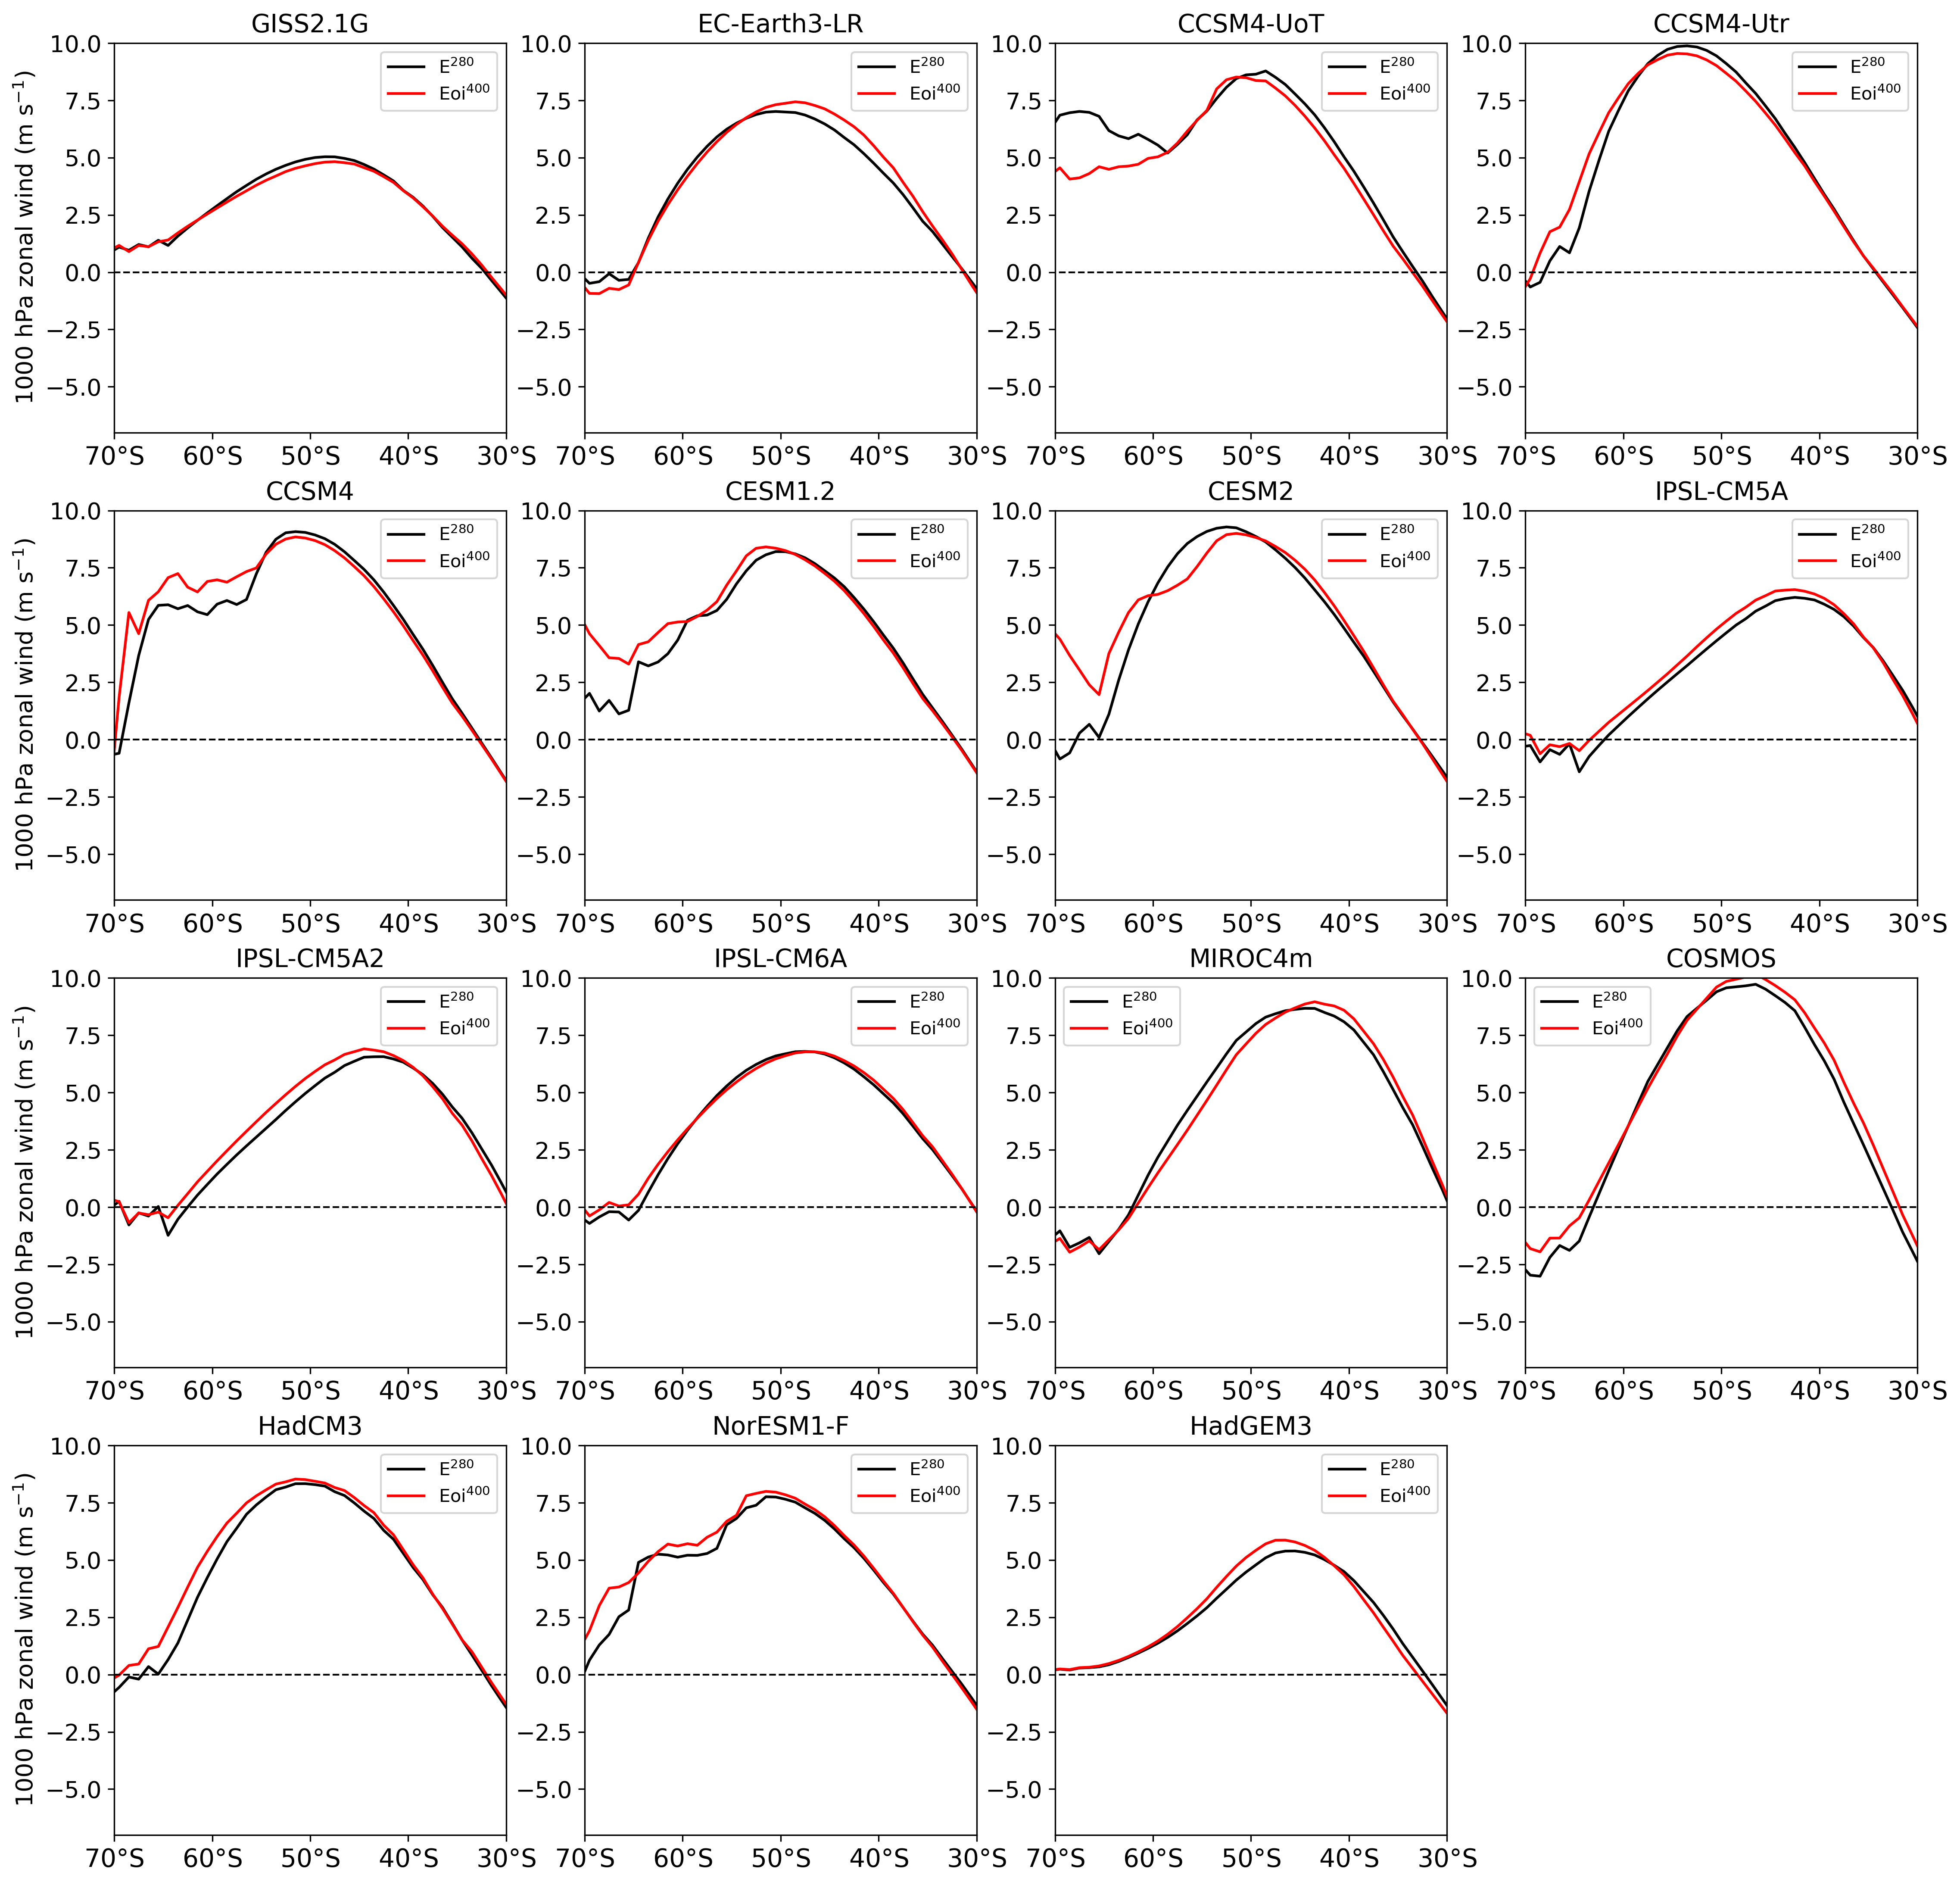

In [4]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize'] = 13

fig = plt.figure(figsize=(18, 18), dpi=300)
outer = gridspec.GridSpec(4, 4, wspace=0.2, hspace=0.2)

x_pos = np.array([-70,-60,-50,-40,-30])
xtext = ('70$\degree$S', '60$\degree$S', '50$\degree$S', '40$\degree$S', '30$\degree$S')

for i in range(len(modellist)):
    model = modellist[i]
    ax = plt.subplot(outer[i])
    im = ax.plot(dsE280.lat, (dsE280.ua[i].where(dsE280.ua[i]>-100).where(dsE280si.si_mean[i]>=0)).mean(dim='lon'), label='E$^{280}$', c='black')
    im = ax.plot(dsE280.lat, (dsEoi400.ua[i].where(dsEoi400.ua[i]>-100).where(dsEoi400si.si_mean[i]>=0)).mean(dim='lon'), label='Eoi$^{400}$', c='red')
    ax.plot([-90,-30],[0,0],linestyle='dashed', linewidth=1, c='k')
    ax.set_xlim([-70,-30])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xtext,fontsize=14)
    ax.set_ylim([-7,10])
    ax.set_title(model, fontsize=14)
    if i ==0 or i ==4 or i ==8 or i ==12:
        ax.set_ylabel(r'1000 hPa zonal wind (m s$^{-1}$)')
    ax.legend()
    fig.add_subplot(ax)   

#plt.savefig('SFig5.png', bbox_inches='tight')

In [5]:
uaE280 = mmmE280.mean(dim=['lon'])
uaEoi400 = mmmEoi400.mean(dim=['lon'])

stdua = (dsEoi400.ua.mean(dim=['lon'])-dsE280.ua.mean(dim='lon')).std(dim='model')
stdua = stdua.where(stdua<100)

In [6]:
coords, mask = mask(dsE280.ua, dsEoi400.ua, mmmEoi400, 12)

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62211/1187255869.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap("cmo.curl",10).copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62211/1187255869.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap("cmo.curl",8).copy()


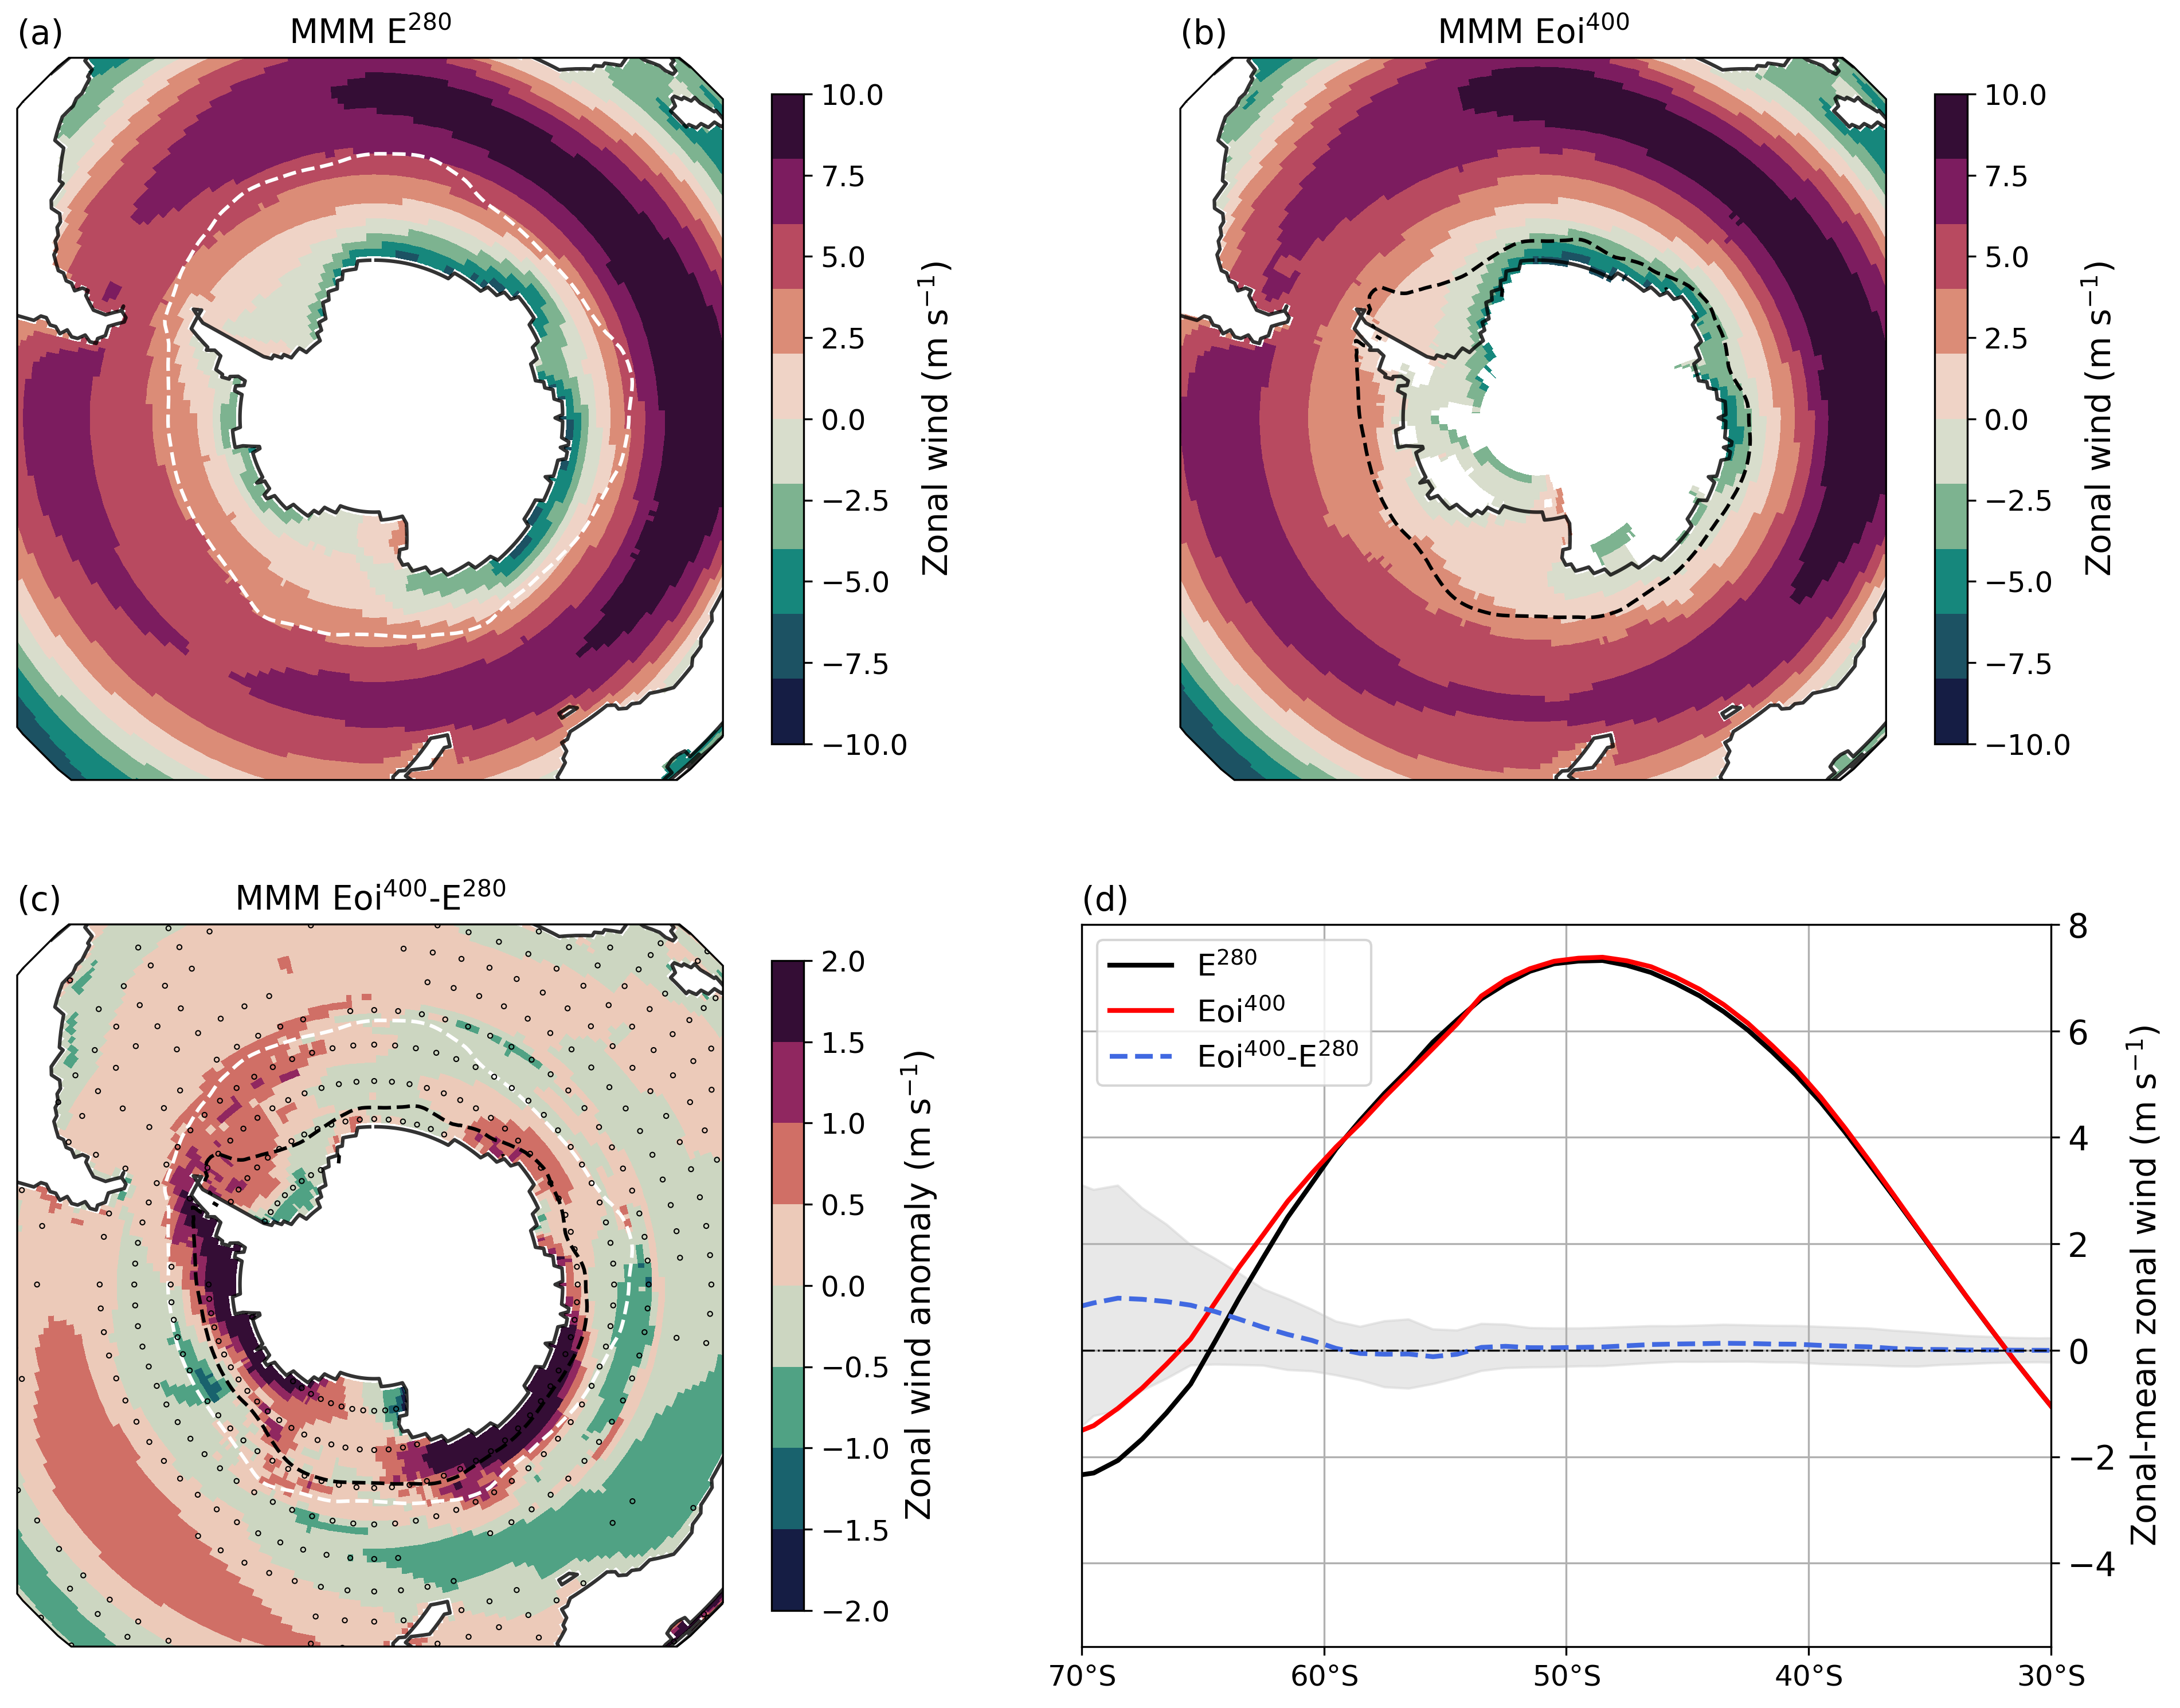

In [7]:
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

## creeer je figuur:
fig = plt.figure(figsize=(16,12), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

cmap0 = plt.cm.get_cmap("cmo.curl",10).copy()
cmap0.set_bad('white')

cmap2 = plt.cm.get_cmap("cmo.curl",8).copy()
cmap2.set_bad('white')

iceline = 15

ax = fig.add_subplot(221, projection=proj)
im=ax.pcolormesh(mmmE280.lon,mmmE280.lat,mmmE280.where(siE280>=0), transform=ccrs.PlateCarree(), cmap=cmap0, vmin = -10, vmax = 10)
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280.where(siE280>=0).where(siEoi400>=0).fillna(-100), colors=['k','k'], linestyles = ['solid'], levels=[-1000,-100], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-40], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Zonal wind (m s$^{-1}$)', fontsize=14)
ax.set_title('MMM E$^{280}$')
ax.set_title('(a)', loc = 'left')

ax = fig.add_subplot(222, projection=proj)
im=ax.pcolormesh(mmmE280.lon,mmmE280.lat,mmmEoi400.where(siEoi400>=0), transform=ccrs.PlateCarree(), cmap=cmap0, vmin = -10, vmax = 10)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['k','k'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280.where(siE280>=0).where(siEoi400>=0).fillna(-100), colors=['k','k'], linestyles = ['solid'], levels=[-1000,-100], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-40], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Zonal wind (m s$^{-1}$)', fontsize=14)
ax.set_title('MMM Eoi$^{400}$')
ax.set_title('(b)', loc = 'left')

ax = fig.add_subplot(223, projection=proj)
im=ax.pcolormesh(mmmE280.lon,mmmE280.lat,(mmmEoi400.where(siE280>=0)-mmmE280.where(siEoi400>=0)), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -2, vmax = 2)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['k','k'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280.where(siE280>=0).where(siEoi400>=0).fillna(-100), colors=['k','k'], linestyles = ['solid'], levels=[-1000,-100], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
cs1 = ax.scatter(coords.lon2D.where(mask==0).where(siE280>=0)[::5,::5], coords.lat2D.where(mask==0).where(siE280>=0)[::5,::5], s=4, facecolors='none', edgecolors='black', linewidth=0.5, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-40], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Zonal wind anomaly (m s$^{-1}$)', fontsize=14)
ax.set_title('MMM Eoi$^{400}$-E$^{280}$')
ax.set_title('(c)', loc = 'left')

x_pos = np.array([-70,-60,-50,-40,-30])
xtext = ('70$\degree$S', '60$\degree$S', '50$\degree$S', '40$\degree$S', '30$\degree$S')

lats = uaE280.lat

ax = fig.add_subplot(224)

ax.plot(lats, uaE280, color='black',linewidth = 2, label='E$^{280}$')
ax.plot(lats, uaEoi400, color='red',linewidth = 2, label='Eoi$^{400}$')
ax.plot(lats, uaEoi400-uaE280, color='royalblue', linewidth =2, linestyle='--', label='Eoi$^{400}$-E$^{280}$')
ax.fill_between(lats, (uaEoi400-uaE280)-stdua, (uaEoi400-uaE280)+stdua, color='lightgrey', alpha=0.5)

ax.legend(fontsize=13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.plot([-80, 80],[0,0], color='black',linewidth=0.8, linestyle='-.')
ax.set_xlim([-70, -30])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)
ax.grid(True)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_title('(d)', loc = 'left')
    
ax.set_ylabel('Zonal-mean zonal wind (m s$^{-1}$)', fontsize=14)
#plt.savefig('Fig5.png', bbox_inches='tight')
plt.show()